# Init

In [ ]:
%%capture
import importlib
from cycler import cycler
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

import sys
sys.path.insert(0, 'geo')
sys.path.insert(0, 'bandstructure')

import caustic_frame
importlib.reload(caustic_frame)

import caustic_bandstructure
importlib.reload(caustic_bandstructure)

from delafossite_bandstructure import delafossite

# Set default plotting parameters

plt.rcParams['axes.prop_cycle'] = cycler(
    color=['#E24A33','#348ABD','#988ED5','#777777',
           '#FBC15E','#8EBA42','#FFB5B8'])

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 2.5
plt.rcParams['xtick.minor.width'] = 1

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['ytick.minor.width'] = 1


plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize']=12

# Generate frame

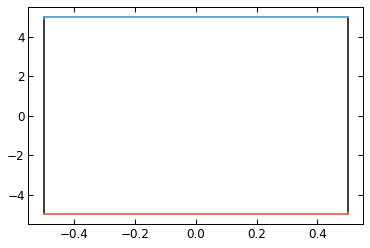

In [2]:
frame = caustic_frame.Frame('geo/bar.dxf')
frame.gen_fig();

In [3]:
frame.edges

[([(-0.5, 5.0), (0.5, 5.0)], 2),
 ([(0.5, 5.0), (0.5, 4.9)], 2),
 ([(0.5, 4.9), (0.5, -4.9)], 0),
 ([(0.5, -4.9), (0.5, -5.0)], 1),
 ([(0.5, -5.0), (-0.5, -5.0)], 1),
 ([(-0.5, -5.0), (-0.5, -4.9)], 1),
 ([(-0.5, -4.9), (-0.5, 4.9)], 0),
 ([(-0.5, 4.9), (-0.5, 5.0)], 2)]

In [4]:
frame.edges[0][0][0][1]

5.0

In [5]:
for edge in frame.edges:
    print(edge[0])

[(-0.5, 5.0), (0.5, 5.0)]
[(0.5, 5.0), (0.5, 4.9)]
[(0.5, 4.9), (0.5, -4.9)]
[(0.5, -4.9), (0.5, -5.0)]
[(0.5, -5.0), (-0.5, -5.0)]
[(-0.5, -5.0), (-0.5, -4.9)]
[(-0.5, -4.9), (-0.5, 4.9)]
[(-0.5, 4.9), (-0.5, 5.0)]


In [6]:
frame.edgenorms

[-1.5707963267948966,
 -3.141592653589793,
 -3.141592653589793,
 -3.141592653589793,
 1.5707963267948966,
 0.0,
 0.0,
 0.0]

# Bandstructure

In [7]:
k = delafossite()
bs = caustic_bandstructure.Bandstructure(k, 0, 10)

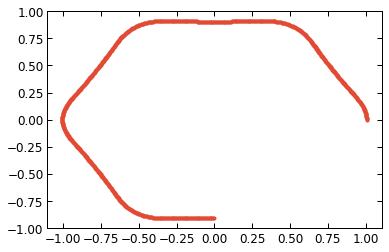

In [8]:
plt.figure()
plt.plot(bs.k[0][:750], bs.k[1][:750], '.')

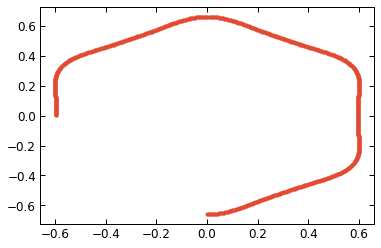

In [9]:
plt.figure()
plt.plot(bs.r[0][:750], bs.r[1][:750], '.')

In [10]:
k = delafossite()
bs = caustic_bandstructure.Bandstructure(k, 0, -10)

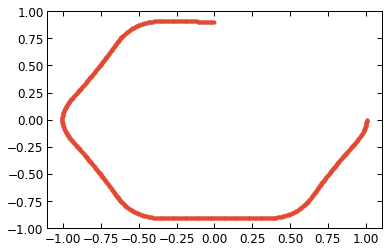

In [11]:
plt.figure()
plt.plot(bs.k[0][:750], bs.k[1][:750], '.')

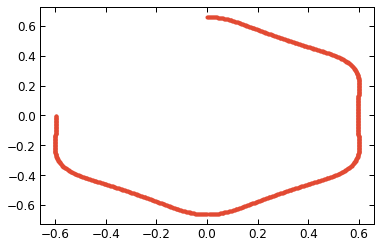

In [12]:
plt.figure()
plt.plot(bs.r[0][:750], bs.r[1][:750], '.')

In [13]:
frame.edges

[([(-0.5, 5.0), (0.5, 5.0)], 2),
 ([(0.5, 5.0), (0.5, 4.9)], 2),
 ([(0.5, 4.9), (0.5, -4.9)], 0),
 ([(0.5, -4.9), (0.5, -5.0)], 1),
 ([(0.5, -5.0), (-0.5, -5.0)], 1),
 ([(-0.5, -5.0), (-0.5, -4.9)], 1),
 ([(-0.5, -4.9), (-0.5, 4.9)], 0),
 ([(-0.5, 4.9), (-0.5, 5.0)], 2)]

In [14]:
frame.edgenorms

[-1.5707963267948966,
 -3.141592653589793,
 -3.141592653589793,
 -3.141592653589793,
 1.5707963267948966,
 0.0,
 0.0,
 0.0]

In [15]:
bs.calculate_injection_probs(frame.edgenorms)

In [16]:
bs.in_prob.keys()

dict_keys([0.0, 1.5707963267948966, -3.141592653589793, -1.5707963267948966])

0.0
1.5707963267948966
-3.141592653589793
-1.5707963267948966


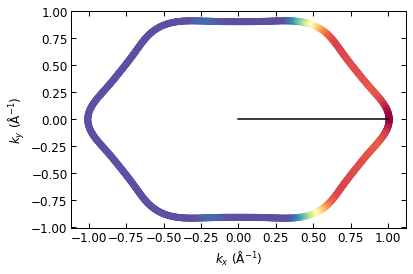

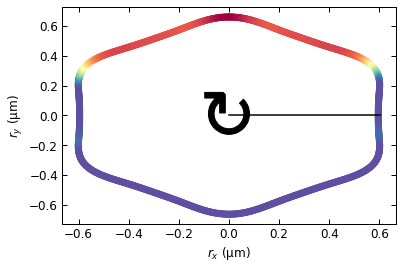

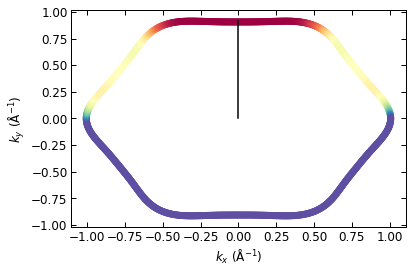

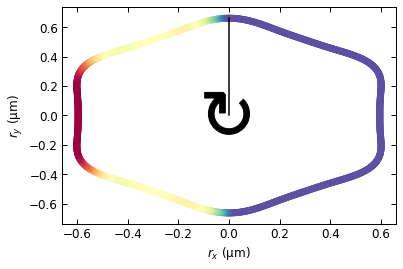

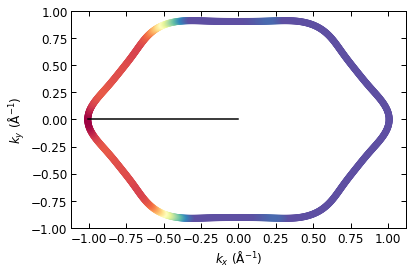

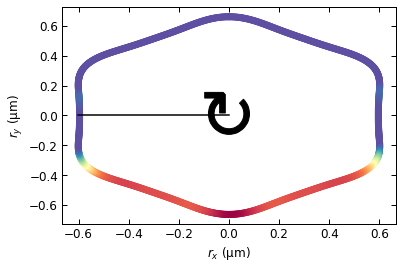

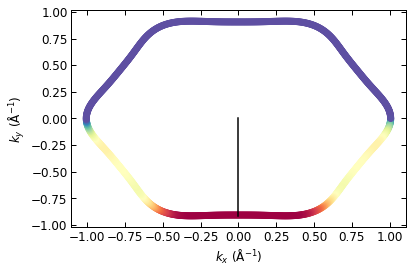

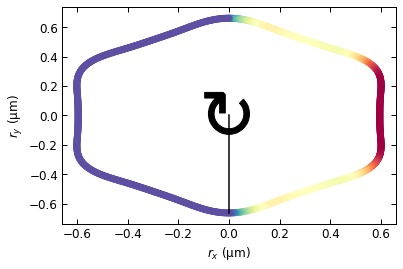

In [25]:
cmap = plt.get_cmap('Spectral_r')

for key in bs.in_prob.keys():
    print(key)
    max_p = np.max(bs.in_prob[key])
    colors = np.array([cmap(p/max_p) for p in bs.in_prob[key]])
    colors = np.append(colors, [colors[0]], axis=0)
    
    fig, ax = plt.subplots()
    plt.plot((0, (np.max(bs.k[0]*np.cos(key)))*np.cos(key)), (0, (np.max(bs.k[1]*np.sin(key)))*np.sin(key)),'k')
    plt.scatter(bs.k[0], bs.k[1],c=colors)
    plt.xlabel(r'$k_x\ (\mathrm{\AA^{-1}})$')
    plt.ylabel(r'$k_y\ (\mathrm{\AA^{-1}})$')
    
    fig, ax = plt.subplots()
    plt.plot([-0.02], [0], marker=r'$\circlearrowright$', ms=50, color='k')
    plt.plot((0, (np.max(bs.r[0]*np.cos(key)))*np.cos(key)), (0, (np.max(bs.r[1]*np.sin(key)))*np.sin(key)),'k')
    plt.scatter(bs.r[0], bs.r[1],c=colors)
    plt.xlabel(r'$r_x\ (\mathrm{\mu m})$')
    plt.ylabel(r'$r_y\ (\mathrm{\mu m})$')

In [18]:
inds = []
n = 10000
freq = np.zeros(999)

for i in range(n):
    ind = bs.get_injection_index(0)
    inds.append(ind)
    freq[ind] += 1
    
prob = freq/n

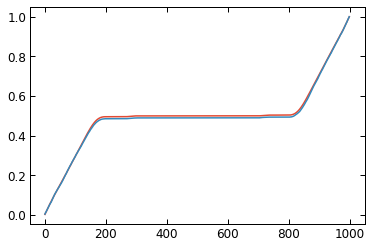

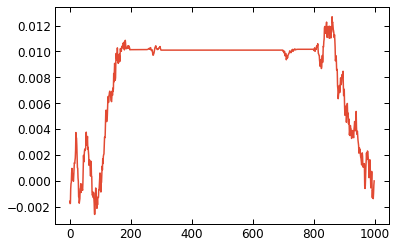

In [19]:
plt.figure()
plt.plot(bs.cum_prob[0])
plt.plot(np.cumsum(prob))

plt.figure()
plt.plot(bs.cum_prob[0]-np.cumsum(prob))